In [1]:
import numpy as np
import MITgcmutils
import matplotlib.pyplot as plt
from utils.resample_to_latlon import resample_to_latlon
from utils.utils import conversion
from glob import glob

path_grid = "ECCO2/LLC270/ECCO-Darwin_extension/grid"
path_3d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_DIC_3d"
path_2d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_2d"

/scratch/somanshu/DeepCarbonMapping/venv_cm/lib/python3.11/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


#### Variable list

In [2]:
fldList_3d = ['TRAC01','ADVxTr01','ADVyTr01','ADVrTr01','DFxETr01','DFyETr01','DFrETr01',
              'DFrITr01','gDAR01','cDIC','cDIC_PIC','respDIC','rDIC_DOC','rDIC_POC','dDIC_PIC']
fldList_2d = ['ETAN','oceFWflx','SFLUX','TFLUX','oceSPflx','oceQsw','fluxCO2','gDICsurf',
           'gDICEpr','gALKEpr','gNO3Epr','gNO2Epr','gNH4Epr','gO2Epr','gPO4Epr','gFeTEpr','gSiO2Epr']

mapping_3d = list(zip(range(len(fldList_3d)),fldList_3d))
mapping_2d = list(zip(range(len(fldList_2d)),fldList_2d))

variable_selection_2d = [6,8]
variable_selection_3d = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14]


display(mapping_3d)
print()
display(mapping_2d)

variable_names = [mapping_3d[idx][1] for idx in variable_selection_3d] + [mapping_2d[idx][1] for idx in variable_selection_2d]

[(0, 'TRAC01'),
 (1, 'ADVxTr01'),
 (2, 'ADVyTr01'),
 (3, 'ADVrTr01'),
 (4, 'DFxETr01'),
 (5, 'DFyETr01'),
 (6, 'DFrETr01'),
 (7, 'DFrITr01'),
 (8, 'gDAR01'),
 (9, 'cDIC'),
 (10, 'cDIC_PIC'),
 (11, 'respDIC'),
 (12, 'rDIC_DOC'),
 (13, 'rDIC_POC'),
 (14, 'dDIC_PIC')]

[(0, 'ETAN'),
 (1, 'oceFWflx'),
 (2, 'SFLUX'),
 (3, 'TFLUX'),
 (4, 'oceSPflx'),
 (5, 'oceQsw'),
 (6, 'fluxCO2'),
 (7, 'gDICsurf'),
 (8, 'gDICEpr'),
 (9, 'gALKEpr'),
 (10, 'gNO3Epr'),
 (11, 'gNO2Epr'),
 (12, 'gNH4Epr'),
 (13, 'gO2Epr'),
 (14, 'gPO4Epr'),
 (15, 'gFeTEpr'),
 (16, 'gSiO2Epr')]

#### importing data

In [3]:
d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.0000002232",rec=variable_selection_2d)
d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.0000002232",rec=variable_selection_3d)

# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/YC")
dxc = MITgcmutils.mds.rdmds(f"{path_grid}/DXC")
dyc = MITgcmutils.mds.rdmds(f"{path_grid}/DYC")
hfacc = MITgcmutils.mds.rdmds(f"{path_grid}/hFacC")

lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]

#### Conversion

In [4]:
# convert 3D variables
for var_idx in range(13):
    d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)

# convert 2D variables
for var_idx in range(2):
    d_2[var_idx] = conversion(d_2[var_idx],variable_names[13+var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
    

#### Flatten 3d data

In [5]:
# getting index of top 100m depth
idx_top_100m = np.where(depth_c>=-100)[0]

# Using numpy
delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m

#### Combine and process variables

In [6]:
# combine data
combined_data = np.concatenate((flattened_d3, d_2), axis=0)

# create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
mask = combined_data[0]==0
combined_data[:,mask] = np.nan

# Interpolating the curvilinear line to the cartesian plane
new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
new_grid_min_lat, new_grid_max_lat = -90, 90
new_grid_min_lon, new_grid_max_lon = -180, 180
new_shape = (combined_data.shape[0],
             int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
             int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))

variables_cart = np.empty(new_shape)

for variable in range(combined_data.shape[0]):  
    lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                resample_to_latlon(lon,lat,combined_data[variable],
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.NaN,
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
                                                                         
variables_cart.shape

(15, 360, 720)

#### plotting

In [ ]:
fig, axes = plt.subplots(figsize=(20, 35))  # Adjust figsize for clarity
values = temp[0]  # Color values for the current variable

# pcolormesh for the current variable
vmax = np.nanmax(values)
vmin = np.nanmin(values)

pcolor = ax.pcolormesh(lon_cart,lat_cart, values, shading='auto',vmin=vmin, vmax=vmax)
cbar = plt.colorbar(pcolor, ax=ax)
cbar.set_label(var_name)

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{var_name}')
plt.subplots_adjust(hspace=0.3)

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_pcolor(ax=None, values=None, lon=None, lat=None, var_name="Variable", vmin=None, vmax=None, cmap='bwr'):
    """
    Plots a single variable on the given axis or creates a new figure if no axis is provided.
    
    Parameters:
    - ax: matplotlib Axes object where the plot will be drawn. If None, a new figure is created.
    - values: 2D numpy array of values to plot.
    - lon: 2D numpy array of longitudes.
    - lat: 2D numpy array of latitudes.
    - var_name: Name of the variable (used in title and colorbar label).
    - vmin: Minimum value for color scale (default: symmetric around 0).
    - vmax: Maximum value for color scale (default: symmetric around 0).
    - cmap: Colormap for the plot (default: 'bwr').
    
    Returns:
    - pcolormesh plot added to the provided axis or a new figure.
    """
    if vmin is None or vmax is None:
        vmax = np.nanmax(np.abs(values))
        vmin = -vmax
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
        standalone = True
    else:
        standalone = False
    
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    # Create the pcolormesh plot
    pcolor = ax.pcolormesh(lon, lat, values, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    
    # Add colorbar
    cbar = plt.colorbar(pcolor, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label(var_name)
    
    # Add labels and title
    ax.set_title(var_name, fontsize=12)
    
    if standalone:
        plt.show()
    
    return pcolor

plot_variable(axes[var_idx], temp[var_idx], lon_cart, lat_cart, var_name)

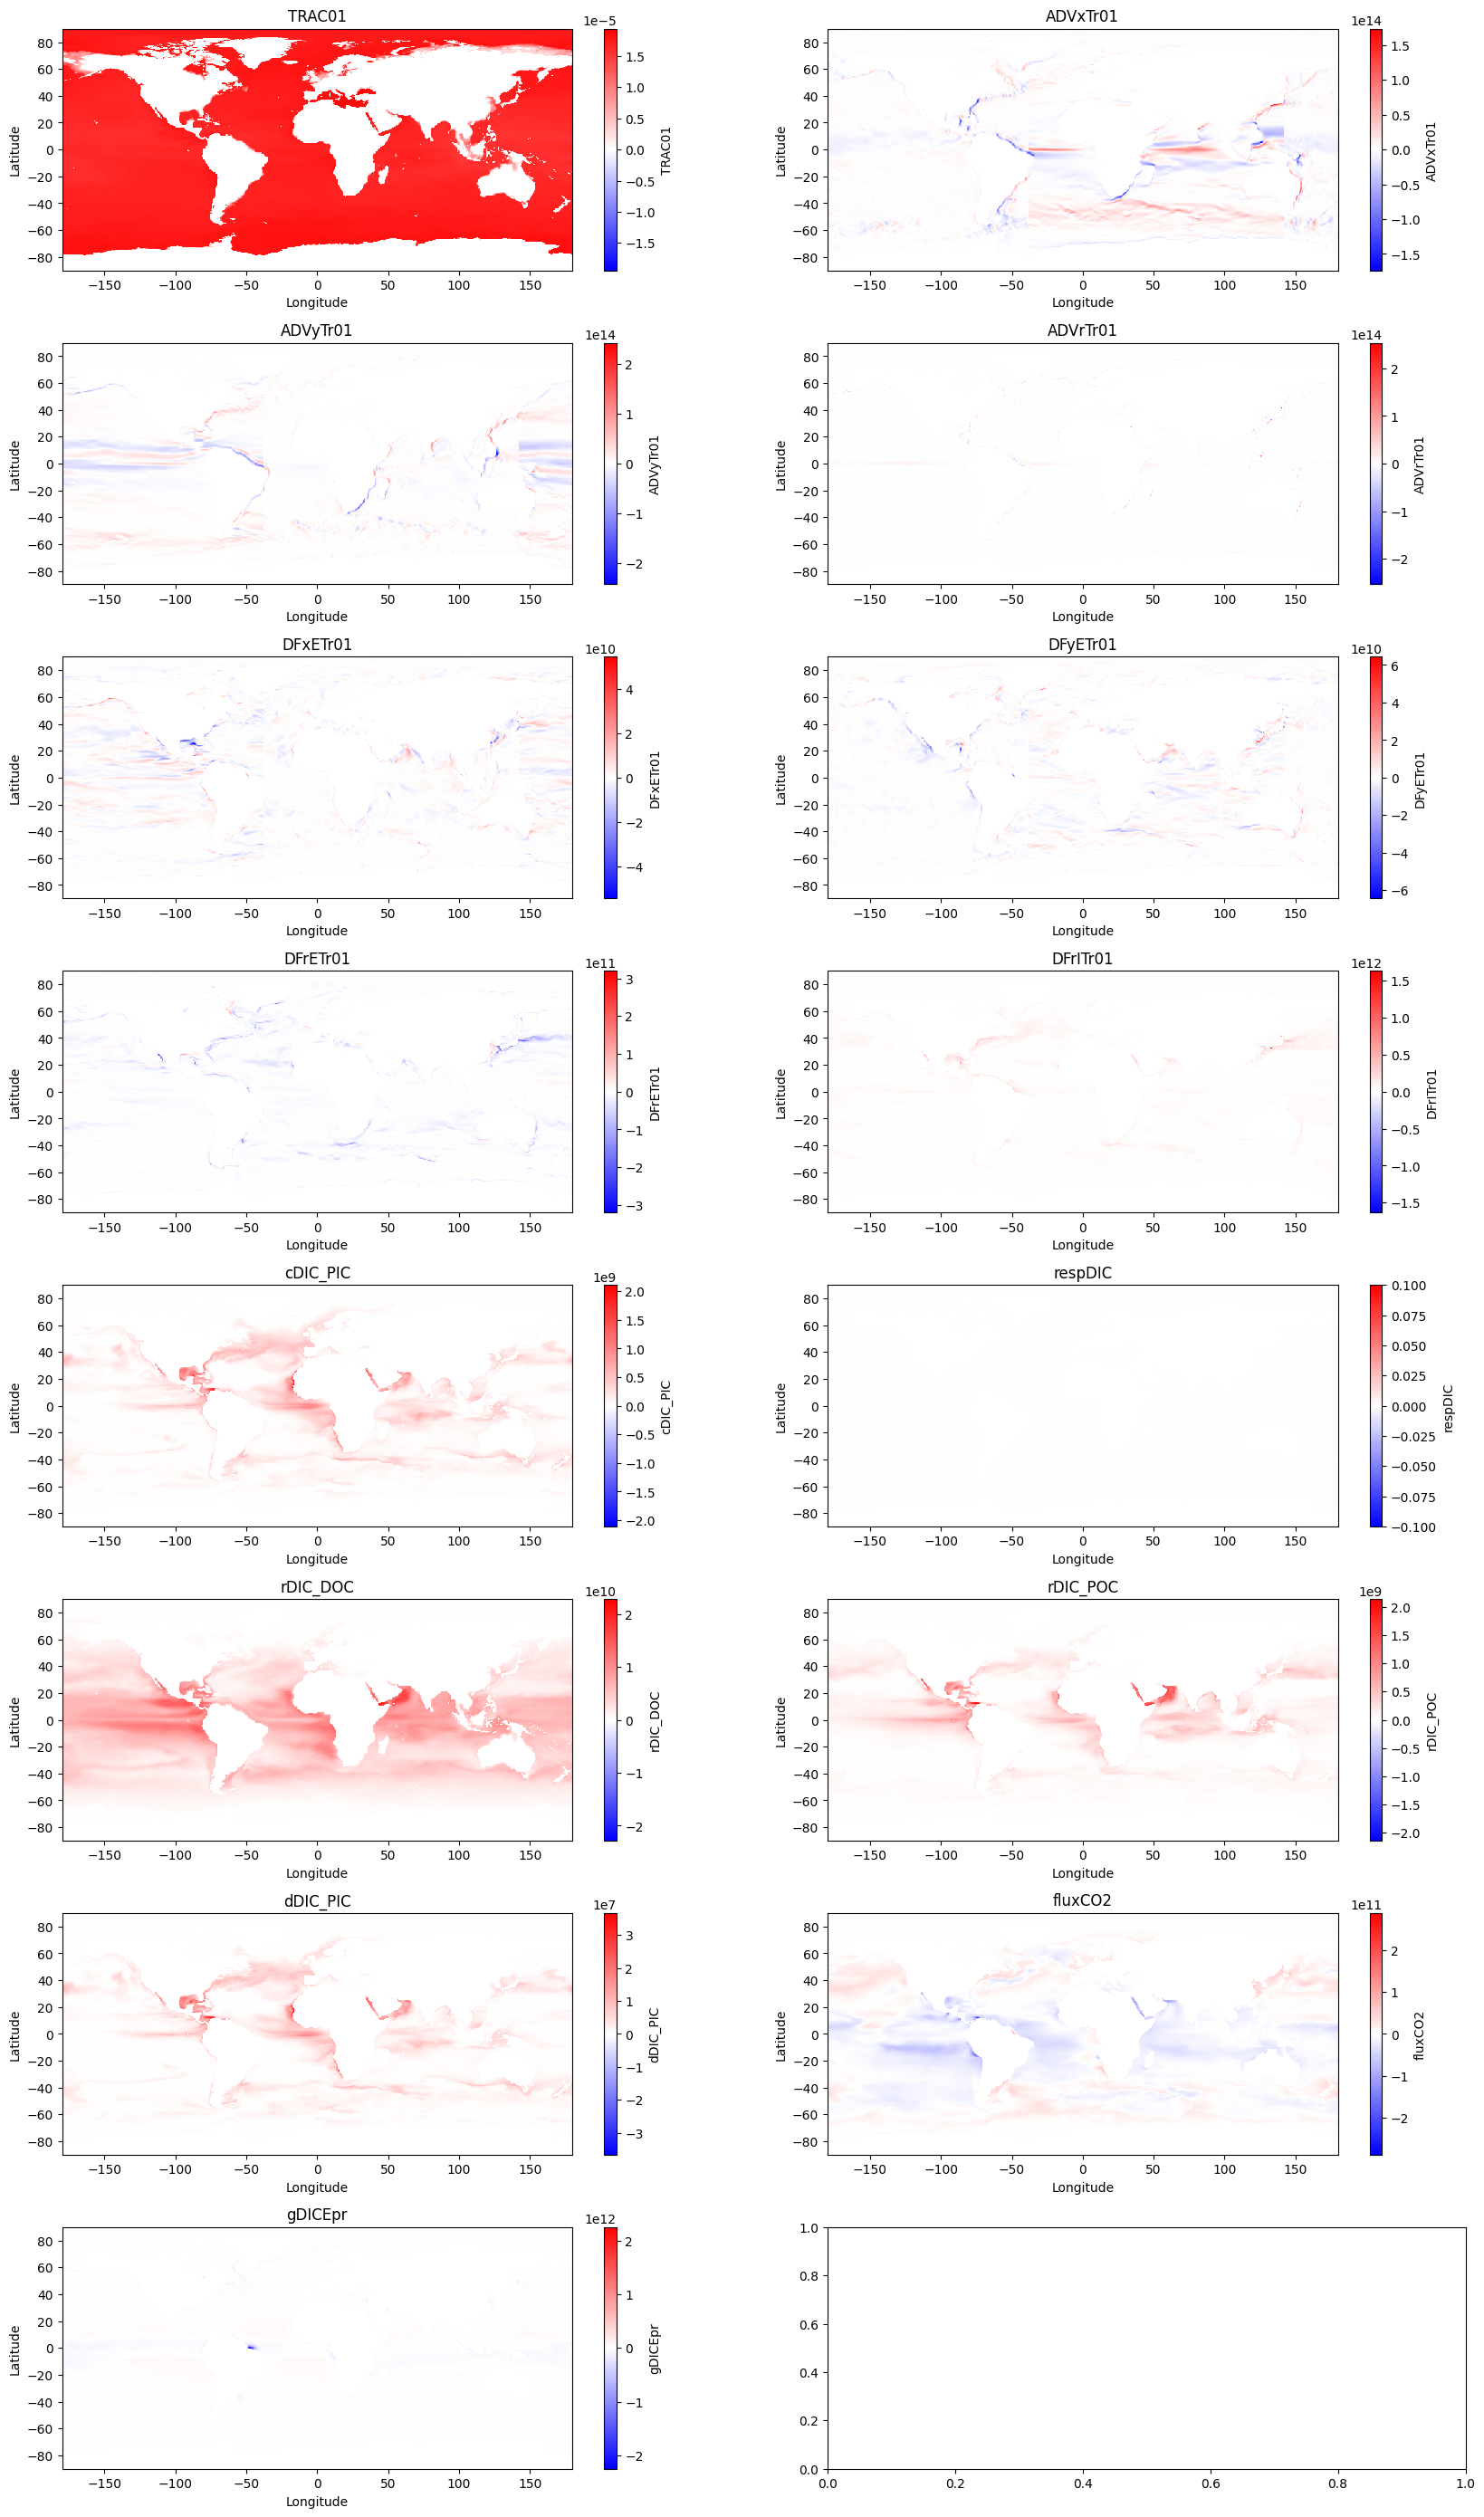

In [39]:
# pcolormesh
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = temp[var_idx]  # Color values for the current variable

    # pcolormesh for the current variable
    vmax = np.nanmax(np.abs(values))
    vmin = -vmax
    
    pcolor = ax.pcolormesh(lon_cart,lat_cart, values, cmap='bwr', shading='auto',vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(pcolor, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)

# plt.savefig("compressed and converted.png", dpi=300, bbox_inches="tight")
plt.show()

#### Integrating accross timestep

In [17]:
# Getting the timestep values
timestep_list = [path.split(".")[1] for path in glob(f"{path_3d}/*.meta")]
timestep_list.sort()

#importing metas
# meta_list = [MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.{timestep}",rec=variable_selection_2d,returnmeta=True)[2] 
#              for timestep in timestep_list]

# timestep_num_list = [int(meta["timestepnumber"][0]) for meta in meta_list]
timestep_num_list = [int(item) for item in timestep_list]

timestep_delta = np.diff(np.array(timestep_num_list), prepend=timestep_num_list[0])
len(timestep_delta)


378

In [20]:
# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/YC")
dxc = MITgcmutils.mds.rdmds(f"{path_grid}/DXC")
dyc = MITgcmutils.mds.rdmds(f"{path_grid}/DYC")
hfacc = MITgcmutils.mds.rdmds(f"{path_grid}/hFacC")

lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]


timestep_list = [path.split(".")[1] for path in glob(f"{path_2d}/*.data")]
timestep_list.sort()

# Initialize sum with checkpointing piece ==========================================================================
checkpoint_list = [int(path.split("_")[4].split(".")[0]) for path in glob(f"checkpoints/*.npy")]
if len(checkpoint_list) > 0:
    checkpoint_list.sort()
    checkpoint_val = checkpoint_list[-1]
    variables_cart_sum_timesteps = np.load(f"checkpoints/variables_cart_final_checkpoint_{checkpoint_val}.npy")
    print(f"Resuming from checkpoint {checkpoint_val}")
else:
    checkpoint_val = -1  # No checkpoint exists, start from scratch
    variables_cart_sum_timesteps = np.zeros(shape=variables_cart.shape)
# ===================================================================================================================
            
for i,(timestep,delta_val) in enumerate(zip(timestep_list,timestep_delta)):
    # checkpointing piece ==========================================================================
    if i <= checkpoint_val:
        continue
    # ==============================================================================================
    
    # print(f"Started running for time step: {timestep}")
    # import 2d and 3d variables ==========================================================================
    d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.{timestep}",rec=variable_selection_2d)
    d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.{timestep}",rec=variable_selection_3d)
    # =========================================================================================================

    # Conversion ===============================================================================================
    # convert 3D variables into standard units
    for var_idx in range(13):
        d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
    
    # convert 2D variables into standard units
    for var_idx in range(2):
        d_2[var_idx] = conversion(d_2[var_idx],variable_names[13+var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
    # =========================================================================================================

    # FLattening ==============================================================================================
    # Flatten 3D variables upto 100m
    idx_top_100m = np.where(depth_c>=-100)[0] # getting index of top 100m depth
    
    # Integrate across Depth=====================================================================================
    delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
    flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m
    # ===========================================================================================================
    
    # Conversion into Cratesian grid ============================================================================
    combined_data = np.concatenate((flattened_d3, d_2), axis=0) # combine data
    
    # create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
    mask = combined_data[0]==0
    combined_data[:,mask] = np.nan
    
    # Interpolating the curvilinear line to the cartesian plane
    new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
    new_grid_min_lat, new_grid_max_lat = -90, 90
    new_grid_min_lon, new_grid_max_lon = -180, 180
    new_shape = (combined_data.shape[0],
                 int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
                 int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))
    
    variables_cart = np.empty(new_shape)
    
    for variable in range(combined_data.shape[0]):  
        lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                    resample_to_latlon(lon,lat,combined_data[variable],
                                    new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                    new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                    fill_value = np.NaN,
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
    # =======================================================================================================
    
    variables_cart_sum_timesteps = variables_cart_sum_timesteps + (variables_cart * delta_val)
    
    
    if i%50 == 0:
        print(f"Saving iteration {i}")
        np.save(f"checkpoints/variables_cart_final_checkpoint_{i}.npy", variables_cart_sum_timesteps)
    if i%20==0:
        print(f"finished {i}. Current timestep: {timestep}")

variables_cart_final = variables_cart_sum_timesteps/sum(timestep_delta)
variables_cart_final.shape

Resuming from checkpoint 350
finished 360. Current timestep: 0000791208


(15, 360, 720)

In [21]:
np.save("variables_cart_final.npy", variables_cart_final)

#### Excel Test

In [58]:
drc = d_3[1]
variable_1_flattened = variable_1_data.reshape(variable_1_data.shape[0], -1)  # Shape: (50, 949770)

# Combine delta depth values with the flattened data
combined_data = np.column_stack((drf, variable_1_flattened))

# Convert to DataFrame for better Excel formatting
column_names = ['Delta Depth'] + [f'Value_{i}' for i in range(variable_1_flattened.shape[1])]
df_excel = pd.DataFrame(combined_data, columns=column_names).T

# Save to Excel
excel_path = "variable_1_depth_comparison.xlsx"
df_excel.to_excel(excel_path, index=False)
